In [1]:
# imports & config
import os
import glob
import math
import random
from collections import defaultdict, Counter
from typing import List, Tuple, Dict

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# paths & data config
DATA = ["/kaggle/input/names-txt/names.txt"]

# model/training config
MAX_NGRAM = 3               # build up to trigram counts
BLOCK_SIZE = 3              # context length fed to MLP
EMBED_DIM = 10              # embedding dimension (matches "respectable" idea)
HIDDEN_DIM = 200            # hidden units in MLP (like makemore MLP)
BATCH_SIZE = 32             # minibatch size (matches original snippet spirit)
MAX_STEPS = 200_000         # number of SGD steps
PRINT_EVERY = 10_000        # how often to print training loss
CLIP_GRAD_NORM = 1.0        # gradient clipping max-norm (for robustness)

# interpolation hyperparameters
ALPHA_LAPLACE = 1.0         # Laplace smoothing for n-grams
K_CONFIDENCE_K = 5.0        # n-gram vs MLP blending hyperparameter

# sampling config
MAX_NAME_LEN = 30
SEED_FOR_SAMPLING = 2147483647


In [2]:
# load dataset & vocabulary

def data_path(candidates):
    for p in candidates:
        if "*" in p:
            found = glob.glob(p)
            if found:
                return found[0]
        if os.path.exists(p):
            return p
    return None

DATA_PATH = data_path(DATA)
if DATA_PATH is None:
    raise FileNotFoundError("names.txt not found. Upload it or adjust DATA.")

with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw_words = [line.strip() for line in f if line.strip()]

words = [w.lower() for w in raw_words]
print(f"Loaded {len(words)} names. Example: {words[:8]}")

# build vocab: dot + letters only
chars = sorted(list(set("".join(words))))
chars = [c for c in chars if c.isalpha()]  # keep alphabetic only

itos = {0: "."}  # special token for start/end
for i, ch in enumerate(chars, start=1):
    itos[i] = ch
stoi = {s: i for i, s in itos.items()}

V = len(itos)
print("Vocab size:", V)
print("Some tokens:", dict(list(itos.items())[:10]))


Loaded 32033 names. Example: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Vocab size: 27
Some tokens: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i'}


In [3]:
# build n-gram (1,2,3) statistics

def build_ngram_counters(corpus: List[str], max_n: int) -> Dict[int, Dict[Tuple[int, ...], Counter]]:
    counters = {n: defaultdict(Counter) for n in range(1, max_n + 1)}
    for w in corpus:
        # encode: . w .  (0 = dot)
        seq = [0] + [stoi[c] for c in w] + [0]
        for n in range(1, max_n + 1):
            ctx_len = n - 1
            for i in range(len(seq) - ctx_len):
                ctx = tuple(seq[i:i+ctx_len]) if ctx_len > 0 else tuple()
                nxt = seq[i+ctx_len]
                counters[n][ctx][nxt] += 1
    return counters

ngram_counters = build_ngram_counters(words, MAX_NGRAM)
for n in range(1, MAX_NGRAM+1):
    print(f"Order {n} contexts: {len(ngram_counters[n])}")

def ngram_probs_for_context(counters, n, context, alpha, vocab_size):
    
    cnts = counters[n].get(context, None)
    if cnts is None:
        # unseen context: use uniform-with-alpha
        arr = np.ones(vocab_size, dtype=float) * alpha
        arr = arr / arr.sum()
        return arr
    arr = np.array([cnts.get(i, 0) for i in range(vocab_size)], dtype=float)
    arr += alpha
    arr = arr / arr.sum()
    return arr


Order 1 contexts: 1
Order 2 contexts: 27
Order 3 contexts: 601


In [4]:
# build supervised dataset for MLP

def build_supervised_dataset(corpus: List[str], block_size: int) -> Tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []
    for w in corpus:
        context = [0] * block_size      # start context = [.,.,.]
        for ch in w + ".":              # predict each char incl final dot
            ix = stoi[ch]
            X.append(list(context))
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    return X, Y

# shuffle words, then 80/10/10 split
random.shuffle(words)
n_words = len(words)
n1 = int(0.8 * n_words)
n2 = int(0.9 * n_words)

Xtr, Ytr = build_supervised_dataset(words[:n1], BLOCK_SIZE)
Xdev, Ydev = build_supervised_dataset(words[n1:n2], BLOCK_SIZE)
Xte, Yte = build_supervised_dataset(words[n2:], BLOCK_SIZE)

print("Shapes Xtr, Xdev, Xte:", Xtr.shape, Xdev.shape, Xte.shape)


Shapes Xtr, Xdev, Xte: torch.Size([182625, 3]) torch.Size([22655, 3]) torch.Size([22866, 3])


In [5]:
# initialize manual MLP parameters

# generator for reproducible init
g_init = torch.Generator().manual_seed(2147483647)

# Embedding matrix: (V, EMBED_DIM)
C = torch.randn((V, EMBED_DIM), generator=g_init) * 0.1

# First layer: (BLOCK_SIZE*EMBED_DIM) -> HIDDEN_DIM
W1 = torch.randn((BLOCK_SIZE * EMBED_DIM, HIDDEN_DIM), generator=g_init) * (1.0 / math.sqrt(BLOCK_SIZE * EMBED_DIM))
b1 = torch.zeros(HIDDEN_DIM)  # biases often safe to start at 0

# Second layer: HIDDEN_DIM -> V
W2 = torch.randn((HIDDEN_DIM, V), generator=g_init) * (1.0 / math.sqrt(HIDDEN_DIM))
b2 = torch.zeros(V)

parameters = [C, W1, b1, W2, b2]
print("Total parameters:", sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

Total parameters: 11897


In [6]:
# training loop (manual SGD)

# learning-rate "range test" (optional for plotting, not strictly used)
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

loss_log = []
step_log = []

g_train = torch.Generator().manual_seed(2147483647 + 1) 

for step in range(MAX_STEPS):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g_train)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    # embedding lookup: (B, block_size, EMBED_DIM)
    emb = C[Xb]                           # (B, 3, d)
    # flatten context: (B, block_size * EMBED_DIM)
    emb_flat = emb.view(-1, BLOCK_SIZE * EMBED_DIM)
    # hidden layer
    h = torch.tanh(emb_flat @ W1 + b1)    # (B, HIDDEN_DIM)
    # logits
    logits = h @ W2 + b2                  # (B, V)
    # cross-entropy loss
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        if p.grad is not None:
            p.grad = None
    loss.backward()

    # gradient clipping (for robustness)
    torch.nn.utils.clip_grad_norm_(parameters, CLIP_GRAD_NORM)

    # update parameters (piecewise-constant LR)
    lr = 0.1 if step < 100_000 else 0.01

    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    loss_log.append(loss.log10().item())
    step_log.append(step)

    if (step + 1) % PRINT_EVERY == 0:
        print(f"step {step+1}/{MAX_STEPS}, loss = {loss.item():.4f}")

print("Training finished.")

step 10000/200000, loss = 1.9712
step 20000/200000, loss = 2.0006
step 30000/200000, loss = 2.2194
step 40000/200000, loss = 2.1084
step 50000/200000, loss = 2.2548
step 60000/200000, loss = 2.4602
step 70000/200000, loss = 2.0358
step 80000/200000, loss = 2.0381
step 90000/200000, loss = 1.9850
step 100000/200000, loss = 2.1121
step 110000/200000, loss = 2.0580
step 120000/200000, loss = 2.2630
step 130000/200000, loss = 2.0021
step 140000/200000, loss = 1.7247
step 150000/200000, loss = 2.0689
step 160000/200000, loss = 2.2246
step 170000/200000, loss = 1.7212
step 180000/200000, loss = 2.1663
step 190000/200000, loss = 2.1121
step 200000/200000, loss = 2.4113
Training finished.


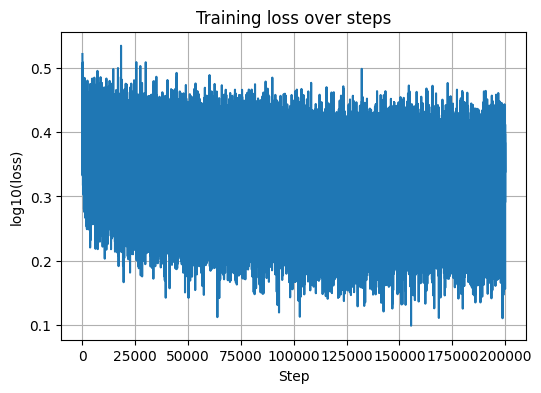

Final train loss: 2.0626
Final dev loss:   2.1090


In [7]:
# evaluation

# Plot log10 loss vs step
plt.figure(figsize=(6,4))
plt.plot(step_log, loss_log)
plt.xlabel("Step")
plt.ylabel("log10(loss)")
plt.title("Training loss over steps")
plt.grid(True)
plt.show()

# Evaluate full train/dev loss
with torch.no_grad():
    # train
    emb_tr = C[Xtr]
    h_tr = torch.tanh(emb_tr.view(-1, BLOCK_SIZE * EMBED_DIM) @ W1 + b1)
    logits_tr = h_tr @ W2 + b2
    loss_tr = F.cross_entropy(logits_tr, Ytr)
    emb_dev = C[Xdev]
    h_dev = torch.tanh(emb_dev.view(-1, BLOCK_SIZE * EMBED_DIM) @ W1 + b1)
    logits_dev = h_dev @ W2 + b2
    loss_dev = F.cross_entropy(logits_dev, Ydev)

print(f"Final train loss: {loss_tr.item():.4f}")
print(f"Final dev loss:   {loss_dev.item():.4f}")

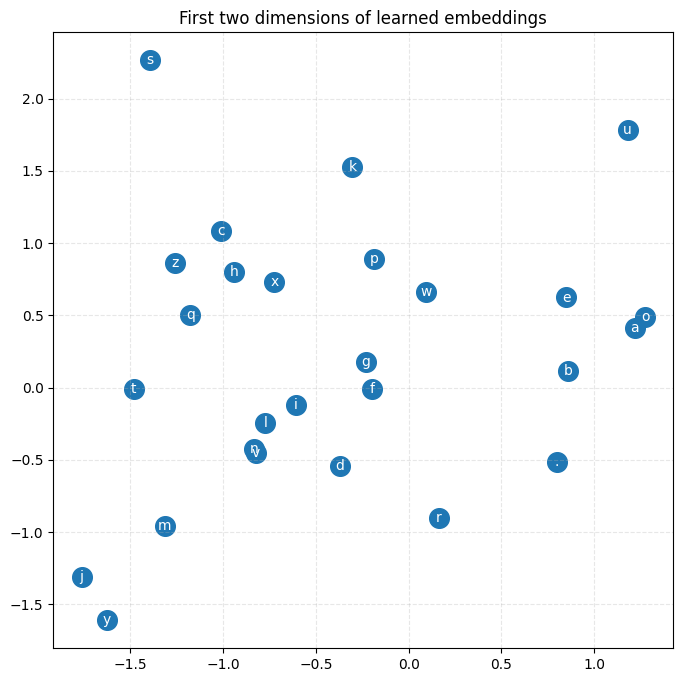

In [8]:
# visualize character embeddings

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].detach().numpy(), C[:,1].detach().numpy(), s=200)

for i in range(V):
    x = C[i,0].item()
    y = C[i,1].item()
    plt.text(x, y, itos[i], ha="center", va="center", color="white")

plt.grid(True, which="both", linestyle="--", alpha=0.3)
plt.title("First two dimensions of learned embeddings")
plt.show()

In [9]:
# MLP probs for a token context

def mlp_probs_for_context(context_tokens: List[int]) -> np.ndarray:
    
    # prepare context of length BLOCK_SIZE (left-pad with dots)
    ctx_for_mlp = [0] * max(0, BLOCK_SIZE - len(context_tokens)) + context_tokens[-BLOCK_SIZE:]
    x = torch.tensor([ctx_for_mlp], dtype=torch.long)  # shape (1, BLOCK_SIZE)

    with torch.no_grad():
        emb = C[x]                             #(1, BLOCK_SIZE, EMBED_DIM)
        emb_flat = emb.view(1, BLOCK_SIZE * EMBED_DIM)
        h = torch.tanh(emb_flat @ W1 + b1)     #(1, HIDDEN_DIM)
        logits = h @ W2 + b2                   #(1, V)
        probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()

    return probs

In [10]:
# combining n-gram and MLP distributions

def get_best_ngram_order_and_context(context_tokens: List[int], counters):

    for order in range(MAX_NGRAM, 0, -1):
        ctx_len = order - 1
        if ctx_len == 0:
            ctx = tuple()
        else:
            if len(context_tokens) < ctx_len:
                continue
            ctx = tuple(context_tokens[-ctx_len:])
        cnt_map = counters[order].get(ctx, None)
        if cnt_map:
            total = sum(cnt_map.values())
            return order, ctx, total
    # fallback to unigram counts
    return 1, tuple(), sum(ngram_counters[1].get(tuple(), Counter()).values())

def compute_combined_distribution(context_tokens: List[int]):
    
    order, ctx, ctx_count = get_best_ngram_order_and_context(context_tokens, ngram_counters)

    # n-gram distribution
    P_ngram = ngram_probs_for_context(ngram_counters, order, ctx, ALPHA_LAPLACE, V)

    # MLP distribution
    P_mlp = mlp_probs_for_context(context_tokens)

    # weight based on context count (confidence in n-gram)
    weight = ctx_count / (ctx_count + K_CONFIDENCE_K)

    P_final = weight * P_ngram + (1.0 - weight) * P_mlp
    # numerical safety
    P_final = np.maximum(P_final, 1e-12)
    P_final = P_final / P_final.sum()
    return P_final, order, ctx, ctx_count, weight

In [11]:
# name generation

def sample_name(prefix: str = "",
                max_len: int = MAX_NAME_LEN,
                seed: int = None,
                temperature: float = 1.0,
                top_k: int = None) -> str:

    # numpy RNG for reproducible sampling if seed is given
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    prefix_chars = [c for c in prefix.lower() if c.isalpha()]
    for c in prefix_chars:
        if c not in stoi:
            raise ValueError(f"Character '{c}' not in vocabulary")

    # sequence starts with dot, then prefix tokens
    seq = [0] + [stoi[c] for c in prefix_chars]
    generated_chars = []

    for _ in range(max_len):
        P_final, order, ctx, cnt, weight = compute_combined_distribution(seq)

        # apply temperature
        if temperature != 1.0:
            logits = np.log(P_final + 1e-20) / temperature
            probs = np.exp(logits - np.max(logits))
            probs = probs / probs.sum()
        else:
            probs = P_final

        # top-k filtering
        if top_k is not None and 0 < top_k < V:
            top_idxs = np.argpartition(-probs, min(top_k, V)-1)[:min(top_k, V)]
            mask = np.zeros_like(probs, dtype=bool)
            mask[top_idxs] = True
            filtered = probs * mask
            if filtered.sum() <= 0:
                filtered = probs
            probs = filtered / filtered.sum()

        # sample next token
        nxt = rng.choice(np.arange(V), p=probs)
        if nxt == 0:
            break  # end token

        generated_chars.append(itos[nxt])
        seq.append(nxt)

        if len(generated_chars) >= max_len:
            break

    prefix_str = "".join(prefix_chars)
    final = (prefix_str + "".join(generated_chars)).capitalize()
    return final

In [12]:
# interactive name generator

def interactive_loop():
    print("N-gram + MLP Name Generator")
    print("Temperature: low = safe/mild, high = creative/chaotic.")
    print("Top-k: restricts sampling to top-k most probable chars.\n")

    while True:
        try:
            prefix = input("Enter starting letters (empty for any, 'exit' to quit): ").strip()
        except Exception:
            print("input() not available in this environment. Exiting interactive mode.")
            break

        if prefix.lower() in ("quit", "exit"):
            print("Exiting.")
            break

        k_str = input("How many names to generate? [default 10]: ").strip()
        try:
            k = int(k_str) if k_str else 10
            if k <= 0:
                raise ValueError()
        except:
            k = 10

        temp_str = input("Temperature (float, default 1.0): ").strip()
        try:
            temperature = float(temp_str) if temp_str else 1.0
        except:
            temperature = 1.0

        topk_str = input("Top-k (int, optional): ").strip()
        try:
            top_k = int(topk_str) if topk_str else None
        except:
            top_k = None

        seed_str = input("Seed (int, optional): ").strip()
        try:
            seed = int(seed_str) if seed_str else None
        except:
            seed = None

        results = []
        attempts = 0
        while len(results) < k and attempts < 10 * k:
            nm = sample_name(prefix=prefix,
                             max_len=MAX_NAME_LEN,
                             seed=(seed + attempts) if seed is not None else None,
                             temperature=temperature,
                             top_k=top_k)
            if nm and nm not in results:
                results.append(nm)
            attempts += 1

        print(f"\nGenerated {len(results)} names (prefix='{prefix}'):")
        for i, nm in enumerate(results, 1):
            print(f"{i:2d}. {nm}")
        print()

        cont = input("Continue? (y/n) [default y]: ").strip().lower()
        if cont in ("n", "no"):
            print("Stopping interactive session.")
            break


interactive_loop()

N-gram + MLP Name Generator
Temperature: low = safe/mild, high = creative/chaotic.
Top-k: restricts sampling to top-k most probable chars.



Enter starting letters (empty for any, 'exit' to quit):  S
How many names to generate? [default 10]:  20
Temperature (float, default 1.0):  0.7
Top-k (int, optional):  2
Seed (int, optional):  43



Generated 14 names (prefix='S'):
 1. Shanna
 2. Sa
 3. Shan
 4. Shann
 5. San
 6. Shi
 7. Sharia
 8. Shari
 9. Sann
10. Shira
11. Shara
12. Sanna
13. Sharian
14. Shir



Continue? (y/n) [default y]:  n


Stopping interactive session.
